# Import libraries, load drive and define path/files

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# %cd "/content/drive/MyDrive/Model for Automated Portfolio Optimization"

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
import random

In [3]:
path = "/content/drive/MyDrive/Model for Automated Portfolio Optimization"
model_file_path = path + "/model"
data = path + "/datat/amibroker_all_data.txt"
data_path = path
dataset_path = path + "/Wave Dataset"

In [4]:
STOCK_TICKER = 0
DATA = 1
TIME = 1
OPEN = 2
HIGH = 3
LOW = 4
CLOSE = 5
VOLUME = 6

def get_history(input):
  return input[1]

def get_time(input):
  return input[0]

def get_high(input):
  return input[1]

def get_low(input):
  return input[2]

def get_close(input):
  return input[3]

def get_volume(input):
  return input[4]

def make_history_block(date_time_ymd, open_price, high_price, low_price, close_price, volume):
  return [date_time_ymd, float(open_price), float(high_price), float(low_price), float(close_price), float(volume)]

In [5]:
with open(data) as stock_data:
    lines = stock_data.read().splitlines()

for i in range(len(lines)):
    lines[i] = lines[i].split(sep=',')

In [6]:
print(lines[0])

['<Ticker>', '<DTYYYYMMDD>', '<Open>', '<High>', '<Low>', '<Close>', '<Volume>000001.SS', '19901219', '99.98', '99.98', '99.98', '99.98', '0']


In [7]:
data = dict()
for i in range(len(lines)):
  data[lines[i][STOCK_TICKER]] = [None, []]

for i in range(len(lines)):
  if lines[i][STOCK_TICKER] != "<Ticker>":
    data[lines[i][STOCK_TICKER]][STOCK_TICKER] = lines[i][STOCK_TICKER]
    data[lines[i][STOCK_TICKER]][DATA].append(make_history_block(lines[i][TIME],
                                                                 lines[i][OPEN],
                                                                 lines[i][HIGH],
                                                                 lines[i][LOW],
                                                                 lines[i][CLOSE],
                                                                 lines[i][VOLUME]))

In [10]:
lst_vn30 = ["MBB", "MSN", "VCB", "ACB", "BID", "PNJ",
            "GAS", "TCB", "CTG", "VJC", "PLX", "BVH",
            "SAB", "STB", "MWG", "PDR", "POW", "GVR",
            "VRE", "NVL", "KDH", "TPB", "VPB", "VNM",
            "HDB", "SSI", "FPT", "VHM", "VIC", "HPG"]

dataset = []

def make_data():
    for i in lst_vn30:
        timeline = [data[i][DATA][x][OPEN:VOLUME] for x in range(0, len(data[i][DATA]))] 
        dataset.append(timeline)
    return

In [11]:
make_data()

In [13]:
print(dataset[3][3499])

[17.472, 17.152, 17.472, 9249711.0]


In [14]:
def divide_list(lst1, lst2):
  ret = []
  for i in range(0, len(lst1)):
    # print(lst1[i], lst2[i])
    if (lst1[i] == 0) and (lst2[i] == 0):
      ret.append(-1)
      continue
    ret.append(2 * (lst1[i]/(lst1[i] + lst2[i]) - 0.5))
  return ret

wave_data = []
for i in range(0, len(dataset)):
  temp_data = []
  for j in range(1, len(dataset[i])):
    # print(i, j)
    temp_data.append(divide_list(dataset[i][j], dataset[i][j-1]))
  wave_data.append(temp_data)

In [16]:
for i in range(0, len(dataset)):
  print(len(dataset[i]), lst_vn30[i])

2722 MBB
3217 MSN
3309 VCB
3954 ACB
2162 BID
3723 PNJ
2587 GAS
1083 TCB
3297 CTG
1397 VJC
1360 PLX
3312 BVH
1451 SAB
4046 STB
2052 MWG
3035 PDR
1144 POW
1133 GVR
1222 VRE
1435 NVL
3156 KDH
1112 TPB
1278 VPB
4163 VNM
1179 HDB
3925 SSI
3937 FPT
1095 VHM
3749 VIC
3727 HPG


In [17]:
set_of_k = [2, 4, 8, 16, 32, 64, 256, 512, 3, 9, 27, 81, 243, 729, 5, 25, 125, 625]
set_of_lag = [0, 1, 2, 4, 8]

In [18]:
def random_shuffle_two_lists(a, b):
  c = list(zip(a, b))
  random.shuffle(c)
  a, b = zip(*c)
  return a, b

In [19]:
def make_f_k_dataset(dataset, k, pick_range, num_of_data_point, lag):
# Dataset[#Stock][#PosTime], K: int, pick_range: tuple[l, r), num_of_data_point: int, r in pick_range must be less than len(dataset) - k
  x_wave = []
  y_wave = []
  pick = []
  for i_0 in range(len(dataset)):
    print(min(pick_range[1], len(dataset[i_0]) - k))
    for i_1 in range(pick_range[0], min(pick_range[1], len(dataset[i_0]) - k)):
      temp = []
      for i_2 in range(0, k - lag):
        temp.append(dataset[i_0][i_1 + i_2])
      x_wave.append(temp)
      # print(i_1 + k, len(dataset[i_0]))
      y_wave.append(dataset[i_0][i_1 + k])
  x_wave, y_wave = random_shuffle_two_lists(x_wave, y_wave)
  print(len(x_wave), len(y_wave))
  x_wave = x_wave[0:min(len(x_wave), num_of_data_point)]
  y_wave = y_wave[0:min(len(y_wave), num_of_data_point)]
  return x_wave, y_wave

In [20]:
from sklearn.linear_model import LinearRegression
import math 
import matplotlib.pyplot as plt

def input_wave(stock_index, start_time, length): # stock_index: example: #0 = MBB, ..., start_time, length, return 4 linear regression slopes [OPEN, HIGH, LOW, VOLUME]
  if len(dataset[stock_index]) < abs(start_time) + length:
    return [0, 0, 0, 0]
  x = [[i] for i in range(0, length)]
  y_open = []
  y_high = []
  y_low = []
  y_volume = []
  for i in range(0, length):
    y_open.append([dataset[stock_index][start_time + i][0]])
    y_high.append([dataset[stock_index][start_time + i][1]])
    y_low.append([dataset[stock_index][start_time + i][2]])
    y_volume.append([dataset[stock_index][start_time + i][3]])
  # print(len(x))
  # 
  # plt.plot(x, y_volume)
  # print(max(y_volume)[0]/min(y_volume)[0])
  x = np.asarray(x)
  y_open = np.asarray(y_open)
  y_high = np.asarray(y_high)
  y_low = np.asarray(y_low)
  y_volume = np.asarray(y_volume)
  model_open = LinearRegression().fit(x, y_open)
  model_high = LinearRegression().fit(x, y_high)
  model_low = LinearRegression().fit(x, y_low)
  model_volume = LinearRegression().fit(x, y_volume)
  # print(model_volume.intercept_)
  return [math.atan(model_open.coef_[0][0]/model_open.intercept_[0]),
          math.atan(model_high.coef_[0][0]/model_high.intercept_[0]),
          math.atan(model_low.coef_[0][0]/model_low.intercept_[0]),
          math.atan(model_volume.coef_[0][0]/model_volume.intercept_[0]),
          ]
  

In [21]:
print(input_wave(1, -1000, 60))

[-0.0007884123774883082, -0.0004756446995520966, -0.000727377314052352, -0.013641435087138623]


In [22]:
def get_stock_value(i, time):
  if i == len(dataset):
    return 1
  if abs(time) >= len(dataset[i]):
    return 1
  return dataset[i][time][0]

def portfolio_to_value(dataset, time, portfolio):
  value = 0
  for i in range(len(dataset)):
    value += get_stock_value(i, time) * portfolio[i]
  return value + portfolio[-1]
  
def reward(start_time, length, portfolio_distribution):
  initial_money = 1000000
  portfolio = [0 for _ in range(len(dataset) + 1)]
  for i in range(len(portfolio)):
    portfolio[i] = initial_money * portfolio_distribution[i] / get_stock_value(i, start_time)
  # print(portfolio)
  max_money = initial_money
  max_risk = 0
  current_money = initial_money
  for i in range(1, length):
    current_money = portfolio_to_value(dataset, start_time + i, portfolio)
    max_risk = max(max_money - current_money, max_risk) 
  return (current_money, max_risk)

In [24]:
portfolio_dummy = [random.randint(1, 1000) for i in range(31)]

def softmax(x):
  x = np.asarray(x)
  return np.exp(x) / np.sum(np.exp(x), axis=0)

def de_softmax(x):
  return np.log(x) - np.average(np.log(x), axis=0)

def prob(x):
  x = np.asarray(x)
  return x / np.sum(x, axis=0)

def add_noise(x):
  x = np.asarray(x)
  x = x + np.random.uniform(-0.1, 0.1, x.shape)
  return x

def generate_random_probability():
  portfolio_dummy = [random.randint(1, 1000) for i in range(31)]
  return prob(portfolio_dummy)

def generate_noise_probability(x):
  return softmax(add_noise(de_softmax(x)))

print(prob(portfolio_dummy))
print(softmax(add_noise(de_softmax(prob(portfolio_dummy)))))
print(generate_noise_probability(portfolio_dummy))

[0.03965915 0.00948232 0.05522809 0.02473091 0.01524859 0.03703229
 0.00153767 0.01377499 0.00563813 0.00832906 0.0435674  0.01704254
 0.01870835 0.05650948 0.05708611 0.06105843 0.01076371 0.00576627
 0.0611225  0.05445925 0.04382368 0.05093542 0.01524859 0.02633265
 0.01928498 0.05183239 0.00320349 0.05093542 0.03921066 0.04407996
 0.0583675 ]
[0.03658828 0.01018495 0.05847174 0.02321062 0.01461593 0.03875021
 0.0014365  0.01484183 0.00570696 0.00797296 0.04181229 0.0172282
 0.01982293 0.05715308 0.06351132 0.06324888 0.01185307 0.00624665
 0.05887145 0.05688258 0.04260222 0.05081852 0.01477489 0.02441242
 0.01922808 0.04885953 0.00332708 0.05112877 0.03882999 0.04217165
 0.05543645]
[0.03708056 0.00925067 0.05319986 0.02673495 0.0151436  0.03701899
 0.00157376 0.01445192 0.0051034  0.0080392  0.04273381 0.01554663
 0.01859942 0.05392935 0.05159634 0.06666187 0.01098984 0.00557203
 0.06375925 0.05444362 0.04447504 0.05221709 0.01652469 0.02847496
 0.02101672 0.05083719 0.00323356 0.0

In [25]:
# def make_data_point(limit_time, length=750):
#   len_time = max([len(dataset[i]) for i in range(len(dataset))])
#   start_time = random.randint(-len_time, limit_time - length)
#   portfolio = generate_random_probability()
#   portfolio_noise = generate_noise_probability(portfolio)
#   # print(portfolio)
#   # print(portfolio_noise)
#   exist = [0 for _ in range(len(dataset))]
#   exist.append(1)
#   for i in range(len(dataset)):
#     if len(dataset[i]) > abs(start_time):
#       exist[i] = 1
#   for i in range(len(exist)):
#     portfolio[i] = portfolio[i] * exist[i]
#     portfolio_noise[i] = portfolio_noise[i] * exist[i]
#   portfolio = prob(portfolio)
#   portfolio_noise = prob(portfolio_noise)
#   reward_portfolio = reward(start_time, length, portfolio)
#   reward_portfolio_noise = reward(start_time, length, portfolio_noise)
#   feature = []
#   for i in range(0, len(dataset)):
#     temp = []
#     if exist[i] != 0:
#       for j in range(2, 8):
#         temp.append([input_wave(i, start_time - 2**j + 1, 2**j), 1])
#     else:
#       for j in range(2, 8):
#         temp.append([[0, 0, 0, 0], 0])
#     feature.append(temp)
#   # print(start_time, -len_time, limit_time - length)
#   # print(portfolio)
#   # print(portfolio_noise)
#   # print(feature)
#   return reward_portfolio, reward_portfolio_noise, portfolio, portfolio_noise, feature

In [26]:
import pickle

In [27]:
# for cnt in range(6, 100):
#   temp_list = []
#   for i in range(0, 10000):
#     print(i)
#     temp = make_data_point(-600)
#     temp_list.append(temp)

#   with open(dataset_path + "/" + "dataset" + str(cnt) + ".pickle", "wb") as fp:
#     pickle.dump(temp_list, fp)

Don't run code below

In [28]:
# with open(dataset_path + "/" + str(0), "rb") as input_file:
#   temp = pickle.load(input_file)
# print(temp)

# Ultilities

In [29]:
import jax.numpy as jnp
from jax import grad, jit, vmap
import jax
import pickle
import functools
import itertools
import operator
import numpy as np
import matplotlib.pyplot as plt
import random
from jax.config import config
config.update("jax_enable_x64", True)

def functools_reduce(a):
    return functools.reduce(operator.concat, a)

def flatten(lst):
  if isinstance(lst, list):
    return functools_reduce([flatten(iter) for iter in lst])
  else:
    return [lst]

# MLP Funcs

In [30]:
PRNGkey = jax.random.PRNGKey(98200289)

In [31]:
COMPONENT_FEATURE_SIZE = 128
MARKET_FEATURE_SIZE = 128

def init_mlp_params(layer_widths):
  global PRNGkey
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=jax.random.normal(key=PRNGkey, shape=(n_in, n_out), dtype=jnp.float64) * jnp.sqrt(2/n_in),
             biases=jnp.zeros(shape=(n_out,), dtype=jnp.float64)
            )
    )
    PRNGkey, subkey = jax.random.split(PRNGkey)
  return params

def forward(params, x):
  *hidden, last = params
  for layer in hidden:
    x = jax.nn.selu(x @ layer['weights'] + layer['biases'])
  return x @ last['weights'] + last['biases']

In [32]:
component_model_params = init_mlp_params([30, 
                                          COMPONENT_FEATURE_SIZE, 
                                          COMPONENT_FEATURE_SIZE, 
                                          COMPONENT_FEATURE_SIZE, 
                                          COMPONENT_FEATURE_SIZE, 
                                          COMPONENT_FEATURE_SIZE, 
                                          COMPONENT_FEATURE_SIZE])
market_model_1_params = init_mlp_params([COMPONENT_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE])

market_model_2_params = init_mlp_params([MARKET_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE])
optimize_model_params = init_mlp_params([COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1, 
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1, 
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1,
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1, 
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1, 
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1,
                                         1])

optimize_model_params_negative = init_mlp_params([COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1, 
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1, 
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1,
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1, 
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1, 
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1,
                                         1])

# @jit
def market_model_forward(market_model_1_params,
                         market_model_2_params,
                         components):
  # @jit
  def forward_market_1(x):
    *hidden, last = market_model_1_params
    for layer in hidden:
      x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']
  # @jit
  def forward_market_2(x):
    *hidden, last = market_model_2_params
    for layer in hidden:
      x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']
  
  vmap_market_model_1_forward_function = vmap(forward_market_1)
  vmap_market_model_2_forward_function = vmap(forward_market_2)
  cur = vmap_market_model_1_forward_function(components)
  cur = jnp.nan_to_num(cur)
  cur = jnp.average(cur, axis=1)
  cur = vmap_market_model_2_forward_function(cur)
  return cur

# @jit
def opt_forward(component_model_params, 
                market_model_1_params,
                market_model_2_params,
                optimize_model_params,
                optimize_model_params_negative,
                wave_data, dist):
  # @jit
  def component_function(x):
    *hidden, last = component_model_params
    x = jnp.nan_to_num(x)
    for layer in hidden:
      x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
      x = jnp.nan_to_num(x)
    x = x @ last['weights'] + last['biases']
    x = jnp.nan_to_num(x)
    return x
  vmap_component_function = vmap(component_function)
  current = vmap(vmap_component_function)(wave_data)
  # print(current)
  current_market = jnp.copy(current)
  current_market = market_model_forward(market_model_1_params,
                                        market_model_2_params,
                                        current_market)
  current_market = jnp.expand_dims(current_market, axis=1)
  current_market = jnp.repeat(current_market, current.shape[1], axis=1)
  dist = jnp.expand_dims(dist, axis=2)
  current = jnp.concatenate([current, current_market, dist], axis=2)
  copy_of_current = jnp.copy(current)
  # @jit
  def forward_opt(x):
    *hidden, last = optimize_model_params
    for layer in hidden:
      x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']
  current = vmap(forward_opt)(current)
  current = jnp.squeeze(current, axis=2)
  current = jax.nn.softmax(current)

  # @jit
  def forward_opt_negative(x):
    *hidden, last = optimize_model_params_negative
    for layer in hidden:
      x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']
  copy_of_current = vmap(forward_opt_negative)(copy_of_current)
  copy_of_current = jnp.squeeze(copy_of_current, axis=2)
  copy_of_current = jax.nn.softmax(copy_of_current) * -1
  return current + copy_of_current

# opt_forward = jax.jit(opt_forward)

In [33]:
component_model_params = jnp.load(model_file_path + '/comp_t.npy', allow_pickle=True)
market_model_1_params = jnp.load(model_file_path + '/mar1_t.npy', allow_pickle=True)
market_model_2_params = jnp.load(model_file_path + '/mar2_t.npy', allow_pickle=True)
optimize_model_params = jnp.load(model_file_path + '/opt_t.npy', allow_pickle=True)
optimize_model_params_negative = jnp.load(model_file_path + '/opt_neg_t.npy', allow_pickle=True)

In [34]:
def check(params, x):
  *hidden, last = params
  for layer in hidden:
    print(type)
    x = jax.nn.selu(x @ layer['weights'] + layer['biases'])
    print(type(layer))
  return x @ last['weights'] + last['biases']

In [35]:
def fix(mat):
  print(len(mat))
  for i in range(len(mat)):
    mat[i]['biases'] = jnp.asarray(mat[i]['biases'], dtype=jnp.float64)
    mat[i]['weights'] = jnp.asarray(mat[i]['weights'], dtype=jnp.float64)

fix(component_model_params)
fix(market_model_1_params)
fix(market_model_2_params)
fix(optimize_model_params)
fix(optimize_model_params_negative)

6
5
5
6
6


# Valid

In [36]:
len_time = max([len(dataset[i]) for i in range(len(dataset))])
length=0
start_time = - length - 1
portfolio = generate_random_probability()
exist = [0 for _ in range(len(dataset))]
exist.append(1)
for i in range(len(dataset)):
    if len(dataset[i]) > abs(start_time):
      exist[i] = 1
for i in range(len(exist)):
  portfolio[i] = portfolio[i] * exist[i]
portfolio = prob(portfolio)
reward_portfolio = reward(start_time, length, portfolio)
feature = []
for i in range(0, len(dataset)):
  temp = []
  if exist[i] != 0:
    for j in range(2, 8):
      temp.append([input_wave(i, start_time - 2**j + 1, 2**j), 1])
  else:
    for j in range(2, 8):
      temp.append([[0, 0, 0, 0], 0])
  feature.append(temp)
feature.append([0 for i in range(30)])
feature = [flatten(x) for x in feature]
feature = jnp.asarray([feature])

In [37]:
print(feature.shape)
print(portfolio.shape)

(1, 31, 30)
(31,)


In [38]:
def get_optimal_t(portfolio, lag=600, length=100):
  len_time = max([len(dataset[i]) for i in range(len(dataset))])
  start_time = -lag - length - 1
  exist = [0 for _ in range(len(dataset))]
  exist.append(1)
  for i in range(len(dataset)):
      if len(dataset[i]) > abs(start_time):
        exist[i] = 1
  feature = []
  for i in range(0, len(dataset)):
    temp = []
    if exist[i] != 0:
      for j in range(2, 8):
        temp.append([input_wave(i, start_time - 2**j + 1, 2**j), 1])
    else:
      for j in range(2, 8):
        temp.append([[0, 0, 0, 0], 0])
    feature.append(temp)
  feature.append([0 for i in range(30)])
  feature = [flatten(x) for x in feature]
  feature = jnp.asarray([feature])
  print(exist)
  X = []
  Y = []
  Ex = []
  Ey = []
  optimal_profit = 0
  optimal_risk = 100000000000
  optimal_T = 0
  SAMPLE = 1
  for t in range(SAMPLE):
    print(t/SAMPLE)
    portfolio = jnp.asarray(portfolio)
    print(type(portfolio))
    for i in range(400):
      res = opt_forward(component_model_params, 
                          market_model_1_params,
                          market_model_2_params,
                          optimize_model_params,
                          optimize_model_params_negative,
                          feature, jnp.asarray([portfolio]))
      reward_portfolio = reward(start_time, length, portfolio)
      res = res[0].at[-1].set(0)
      portfolio = portfolio + res
      def temp_less_zero(x):
        return jax.lax.cond(x <= 0.0,
                    x, lambda x: 0.0,
                    x, lambda x: x)
      portfolio = vmap(temp_less_zero)(portfolio)
      # print(portfolio)
      portfolio = prob(portfolio)
      # print(sum(portfolio))
      reward_portfolio_noise = reward(start_time, length, portfolio)
      # print(reward_portfolio, reward_portfolio_noise)
      X = (reward_portfolio[0])
      Y = (reward_portfolio[1])
      Ex = (reward_portfolio_noise[0] - reward_portfolio[0])
      Ey = (reward_portfolio_noise[1] - reward_portfolio[1])
      if reward_portfolio_noise[0] > optimal_profit and reward_portfolio_noise[1] < optimal_risk:
        optimal_T = i + 1
        optimal_profit = reward_portfolio_noise[0]
        optimal_risk = reward_portfolio_noise[1]
      print(optimal_T, i/400, optimal_profit, optimal_risk, reward_portfolio_noise[0], reward_portfolio_noise[1])
      if  i - optimal_T > 10:
        break
      # print(X, Y, Ex, Ey)
  return optimal_T

In [ ]:
len_time = max([len(dataset[i]) for i in range(len(dataset))])
length=100
start_time = - length - 1
portfolio = generate_random_probability()
exist = [0 for _ in range(len(dataset))]
exist.append(1)
for i in range(len(dataset)):
    if len(dataset[i]) > abs(start_time):
      exist[i] = 1
for i in range(len(exist)):
  portfolio[i] = portfolio[i] * exist[i]
portfolio = prob(portfolio)
reward_portfolio = reward(start_time, length, portfolio)
feature = []
for i in range(0, len(dataset)):
  temp = []
  if exist[i] != 0:
    for j in range(2, 8):
      temp.append([input_wave(i, start_time - 2**j + 1, 2**j), 1])
  else:
    for j in range(2, 8):
      temp.append([[0, 0, 0, 0], 0])
  feature.append(temp)
feature.append([0 for i in range(30)])
feature = [flatten(x) for x in feature]
feature = jnp.asarray([feature])

X = []
Y = []
Ex = []
Ey = []
portfolios = []
SAMPLE = 10
for t in range(SAMPLE):
  print(t/SAMPLE)
  portfolio = generate_random_probability()
  port_ = np.copy(portfolio)
  optt = 150
  portfolio = jnp.asarray(portfolio)
  print(type(portfolio))
  for i in range(optt):
    print(i/optt, optt)
    res = opt_forward(component_model_params, 
                        market_model_1_params,
                        market_model_2_params,
                        optimize_model_params,
                        optimize_model_params_negative,
                        feature, jnp.asarray([portfolio]))
    reward_portfolio = reward(start_time, length, portfolio)
    res = res[0].at[-1].set(0)
    portfolio = portfolio + res
    def temp_less_zero(x):
      return jax.lax.cond(x <= 0.0,
                  x, lambda x: 0.0,
                  x, lambda x: x)
    portfolio = vmap(temp_less_zero)(portfolio)
    # print(portfolio)
    portfolio = prob(portfolio)
    # print(sum(portfolio))
    reward_portfolio_noise = reward(start_time, length, portfolio)
    # print(reward_portfolio, reward_portfolio_noise)
    X = (reward_portfolio[0])
    Y = (reward_portfolio[1])
    Ex = (reward_portfolio_noise[0] - reward_portfolio[0])
    Ey = (reward_portfolio_noise[1] - reward_portfolio[1])
    # print(X, Y, Ex, Ey)
    plt.quiver(X, Y, Ex, Ey, angles='xy', scale_units='xy', scale=1, color='g')
  portfolios.append(portfolio)
ax = plt.gca()
plt.grid()
plt.show()
ax = plt.gca()

In [40]:
print(portfolios)
reward(start_time, length, portfolio)

[array([0.        , 0.06932779, 0.08983206, 0.03833995, 0.        ,
       0.        , 0.        , 0.0884647 , 0.        , 0.        ,
       0.        , 0.        , 0.20876008, 0.        , 0.0084131 ,
       0.        , 0.        , 0.        , 0.29879359, 0.        ,
       0.        , 0.        , 0.03387827, 0.        , 0.08643639,
       0.01800132, 0.        , 0.05171473, 0.        , 0.00390425,
       0.00413377]), array([0.02004215, 0.04195676, 0.0774596 , 0.07266413, 0.        ,
       0.00056513, 0.        , 0.03877702, 0.        , 0.        ,
       0.        , 0.        , 0.191903  , 0.        , 0.01488579,
       0.        , 0.0244718 , 0.        , 0.29883329, 0.        ,
       0.        , 0.        , 0.00445236, 0.        , 0.08156799,
       0.03555435, 0.        , 0.05432047, 0.00373025, 0.03687694,
       0.00193897]), array([0.        , 0.07576427, 0.06761102, 0.07467044, 0.        ,
       0.        , 0.        , 0.05715553, 0.        , 0.        ,
       0.        , 

(955753.5148201374, 94751.73337943398)

In [41]:
def get_lst_nav(start_time, length, portfolio_distribution):
  initial_money = 1000000
  cur = [initial_money]
  portfolio = [0 for _ in range(len(dataset) + 1)]
  for i in range(len(portfolio)):
    portfolio[i] = initial_money * portfolio_distribution[i] / get_stock_value(i, start_time)
  # print(portfolio)
  max_money = initial_money
  max_risk = 0
  current_money = initial_money
  for i in range(1, length):
    current_money = portfolio_to_value(dataset, start_time + i, portfolio)
    cur.append(current_money)
    max_risk = max(max_money - current_money, max_risk) 
  return cur

test_portfolio = np.average(np.asarray(portfolios), axis=0)
print(test_portfolio)
for i in range(0, len(test_portfolio)):
  print(lst_vn30[i] + ":" + str(test_portfolio[i]))
print(portfolios[0])

[0.00699536 0.0654692  0.09317935 0.05714939 0.         0.00088644
 0.         0.06570465 0.         0.         0.         0.
 0.18285704 0.00216871 0.01222656 0.         0.0096102  0.
 0.2882085  0.         0.         0.         0.03812001 0.
 0.0701405  0.02523798 0.         0.04773838 0.00373861 0.01999637
 0.01057274]
MBB:0.006995361227471038
MSN:0.06546920471873621
VCB:0.09317935133349967
ACB:0.05714938782530886
BID:0.0
PNJ:0.0008864410941696049
GAS:0.0
TCB:0.06570464758037267
CTG:0.0
VJC:0.0
PLX:0.0
BVH:0.0
SAB:0.1828570423066857
STB:0.0021687061023763104
MWG:0.01222656317783298
PDR:0.0
POW:0.009610199912280213
GVR:0.0
VRE:0.2882084955809586
NVL:0.0
KDH:0.0
TPB:0.0
VPB:0.03812001033736952
VNM:0.0
HDB:0.07014049561953886
SSI:0.025237978367204445
FPT:0.0
VHM:0.047738383105529525
VIC:0.003738613215751957
HPG:0.019996374195873197


IndexError: ignored

In [42]:
portfolio_equal = [1/30 for i in range(30)]
portfolio_equal.append(0)

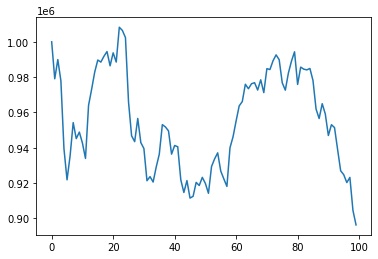

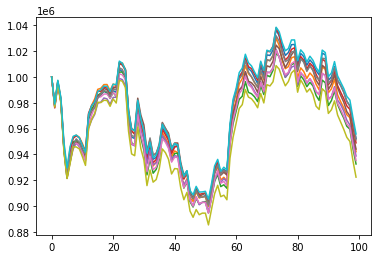

In [43]:
# y = get_lst_nav(start_time, length, test_portfolio)
lst = []
for x in portfolios:
  lst.append(get_lst_nav(start_time, length, x))
y_ = get_lst_nav(start_time, length, portfolio_equal)
plt.plot(y_)
plt.show()
for x in lst:
  plt.plot(x)
plt.show()

In [44]:
print(test_portfolio)
test_portfolio2 = []
for i in test_portfolio:
  test_portfolio2.append(i)
test_portfolio2[-1] = 0
s_test2 = sum(test_portfolio2)
for i in range(len(test_portfolio2)):
  test_portfolio2[i] /= s_test2
print(test_portfolio2)
print(sum(test_portfolio2))

[0.00699536 0.0654692  0.09317935 0.05714939 0.         0.00088644
 0.         0.06570465 0.         0.         0.         0.
 0.18285704 0.00216871 0.01222656 0.         0.0096102  0.
 0.2882085  0.         0.         0.         0.03812001 0.
 0.0701405  0.02523798 0.         0.04773838 0.00373861 0.01999637
 0.01057274]
[0.007070111710754497, 0.0661687904204282, 0.09417503995024554, 0.05776007027906401, 0.0, 0.0008959133570073385, 0.0, 0.06640674915896089, 0.0, 0.0, 0.0, 0.0, 0.18481100177207133, 0.002191880292240273, 0.01235721282932627, 0.0, 0.009712891834045818, 0.0, 0.29128821135696065, 0.0, 0.0, 0.0, 0.03852735015912151, 0.0, 0.07088999743578708, 0.025507664380363775, 0.0, 0.04824850218191056, 0.003778562996127833, 0.020210049885584332, 0.0]
0.9999999999999998


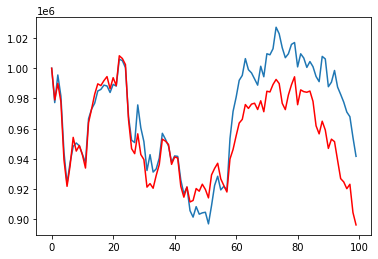

941718.4956053542


In [45]:
y = get_lst_nav(start_time, length, test_portfolio2)
y_ = get_lst_nav(start_time, length, portfolio_equal)
plt.plot(y)
plt.plot(y_, color='red')
plt.show()
print(y[-1])

In [ ]:
y__ = np.asarray(y) / np.asarray(y_)
plt.plot(y__)
plt.show()
y__[-1]

In [ ]:
print(reward(start_time, length, portfolio_equal))
print(reward(start_time, length, test_portfolio2))

In [ ]:
for i in range(30):
  print(lst_vn30[i], test_portfolio[i])
print("Fiat", test_portfolio[30])